# **RAFT Model Train**

In this notebook, we will train our RAFT based model on the training data

In [1]:
import os
import sys
import time
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *
from model import Network
from dataset import MarsDataset

### Constants

In [3]:
ROOT = r"C:\Users\itber\Documents\datasets\mars_auto"
CHECKPOINT = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\models"
DEVICE = "cuda"
H, W = 540, 720 # standard image size
H2, W2 = 270, 360 # halfsize image

BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 5e-4

torch.backends.cudnn.benchmark = True

### Get Augmentations

Don't normalize anything since model already has normalization built into it's forward pass

In [4]:
import torchvision
from torchvision import transforms

train_transforms = transforms.Compose([
                                transforms.RandomResizedCrop((H, W), scale=(0.25, 1.0)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomVerticalFlip(0.1),
                                # transforms.RandomRotation((-10, 10))
                                ])

### Get Data with Random Splits

In [5]:
from torch.utils.data import DataLoader


train_dataset = MarsDataset(ROOT, transform=train_transforms, split='train')
valid_dataset = MarsDataset(ROOT, transform=None, split='valid')
test_dataset = MarsDataset(ROOT, transform=None, split='test')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

### Check that dataloaders are working

In [6]:
(image1, image2), speed = next(iter(train_loader))
image1.min(), image1.max()

(tensor(3.0125e-06), tensor(255.0000))

Text(0.5, 1.0, 'frame_3310.png')

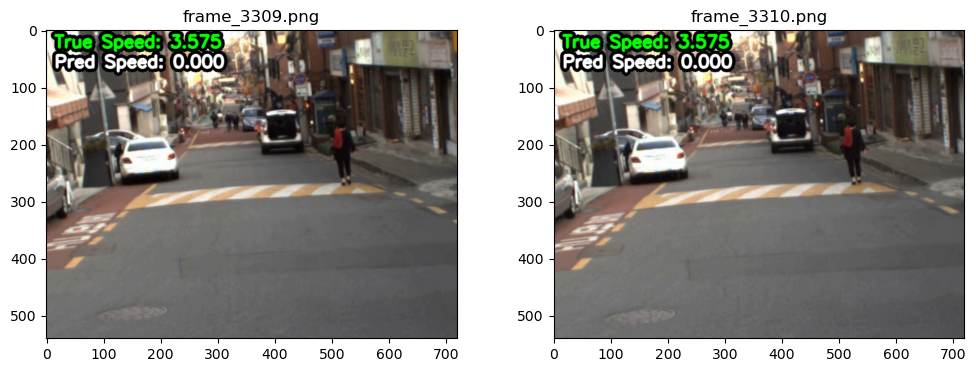

In [7]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(viz(image1[idx, :, :, :].squeeze(), 
                 train_dataset.unstandardize(speed[idx]), 
                 0))
ax[0].set_title(os.path.basename(train_dataset.image_path1))
ax[1].imshow(viz(image2[idx, :, :, :].squeeze(), 
                 train_dataset.unstandardize(speed[idx]), 
                 0))
ax[1].set_title(os.path.basename(train_dataset.image_path2))

### Get Model

In [8]:
raft_model = load_model("RAFT/models/raft-sintel.pth", args=Args())
fnet = raft_model.module.fnet

model = Network(fnet, freeze_encoder=True)

### Training Utils

In [9]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, window_size=None):
        self.values = []
        self.length = len(self.values)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.values.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [10]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

## Train Loop

In [11]:
model_root = r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models'

model.to(DEVICE).train()

# scaling parameter for loss function
# c = 0.5

best_valid_loss = np.inf

avg_train_metrics = {
    'losses' : [],
}

avg_valid_metrics = {
    'losses' : [],
}


for e in range(EPOCHS):
    train_metrics = {
        'losses' : AverageMeter(),
    }

    model.train()

    for i, ((image1, image2), speed) in enumerate(train_loader):
        image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

        # pad to ensure that it is divisible by 8
        padder = InputPadder(image1.shape, mode=None)
        image1, image2 = padder.pad(image1, image2)

        # get predictions
        pred_speed = model(image1, image2)

        # compute losses
        loss = criterion(pred_speed, speed)

        # zero gradients 
        optimizer.zero_grad()

        # back prop loss
        loss.backward()

        # step weights
        optimizer.step()

        # store metrics
        train_metrics['losses'].update(loss.item())

        if i % 50 == 0:
            print(f"train: epoch {e} - iteration: {i} - MSE loss: {train_metrics['losses'].avg}") 
            
            # # cooldown
            # time.sleep(5)
    
    # save average metrics
    avg_train_metrics['losses'].append(np.round(train_metrics['losses'].avg, 3))


    # display train metrics
    print(f"train epoch {e} - avg MSE loss: {avg_train_metrics['losses'][-1]}")

    # validate model
    valid_metrics = {
        'losses' : AverageMeter()
    }

    model.eval()
    with torch.no_grad():
        for i, ((image1, image2), speed) in enumerate(valid_loader):
            image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

            # pad to ensure that it is divisible by 8
            padder = InputPadder(image1.shape, mode=None)
            image1, image2 = padder.pad(image1, image2)

            # get predictions
            pred_speed = model(image1, image2)

            # compute losses
            loss = criterion(pred_speed, speed)

            # store metrics
            valid_metrics['losses'].update(loss.item())

            if i % 50 == 0:
                print(f"valid: epoch {e} - MSE loss: {valid_metrics['losses'].avg}")

        # save average metrics
        avg_valid_metrics['losses'].append(np.round(valid_metrics['losses'].avg, 3))

        # display valid metrics
        print(f"valid: epoch {e} - avg MSE loss: {avg_valid_metrics['losses'][-1]}")

        # save best model based on overall loss
        if avg_valid_metrics['losses'][-1] <= best_valid_loss:
            best_valid_loss = avg_valid_metrics['losses'][-1]

            # save model
            model_savepath = os.path.join(CHECKPOINT, f"model_{e}.pth")

            torch.save(model.state_dict(), model_savepath) # save state dict

    # # cooldown
    # time.sleep(5)

c:\Users\itber\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


train: epoch 0 - iteration: 0 - MSE loss: 0.9866
train: epoch 0 - iteration: 50 - MSE loss: 0.8802
train: epoch 0 - iteration: 100 - MSE loss: 0.6784
train: epoch 0 - iteration: 150 - MSE loss: 0.5911
train: epoch 0 - iteration: 200 - MSE loss: 0.5532
train: epoch 0 - iteration: 250 - MSE loss: 0.5121
train: epoch 0 - iteration: 300 - MSE loss: 0.4885
train: epoch 0 - iteration: 350 - MSE loss: 0.4784
train: epoch 0 - iteration: 400 - MSE loss: 0.4636
train: epoch 0 - iteration: 450 - MSE loss: 0.4484
train: epoch 0 - iteration: 500 - MSE loss: 0.4325
train: epoch 0 - iteration: 550 - MSE loss: 0.4195
train: epoch 0 - iteration: 600 - MSE loss: 0.4112
train: epoch 0 - iteration: 650 - MSE loss: 0.4013
train: epoch 0 - iteration: 700 - MSE loss: 0.3982
train: epoch 0 - iteration: 750 - MSE loss: 0.3981
train: epoch 0 - iteration: 800 - MSE loss: 0.3918
train epoch 0 - avg MSE loss: 0.39
valid: epoch 0 - MSE loss: 0.8923
valid: epoch 0 - MSE loss: 0.9796
valid: epoch 0 - MSE loss: 1.0133

c:\Users\itber\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


valid: epoch 0 - avg MSE loss: 1.003
train: epoch 1 - iteration: 0 - MSE loss: 0.1682
train: epoch 1 - iteration: 50 - MSE loss: 0.3032
train: epoch 1 - iteration: 100 - MSE loss: 0.2868
train: epoch 1 - iteration: 150 - MSE loss: 0.283
train: epoch 1 - iteration: 200 - MSE loss: 0.3074
train: epoch 1 - iteration: 250 - MSE loss: 0.3143
train: epoch 1 - iteration: 300 - MSE loss: 0.3067
train: epoch 1 - iteration: 350 - MSE loss: 0.3043
train: epoch 1 - iteration: 400 - MSE loss: 0.3054
train: epoch 1 - iteration: 450 - MSE loss: 0.3003
train: epoch 1 - iteration: 500 - MSE loss: 0.2936
train: epoch 1 - iteration: 550 - MSE loss: 0.2914
train: epoch 1 - iteration: 600 - MSE loss: 0.2941
train: epoch 1 - iteration: 650 - MSE loss: 0.2931
train: epoch 1 - iteration: 700 - MSE loss: 0.2934
train: epoch 1 - iteration: 750 - MSE loss: 0.2919
train: epoch 1 - iteration: 800 - MSE loss: 0.2896
train epoch 1 - avg MSE loss: 0.29
valid: epoch 1 - MSE loss: 0.6499
valid: epoch 1 - MSE loss: 0.89

Display Metrics

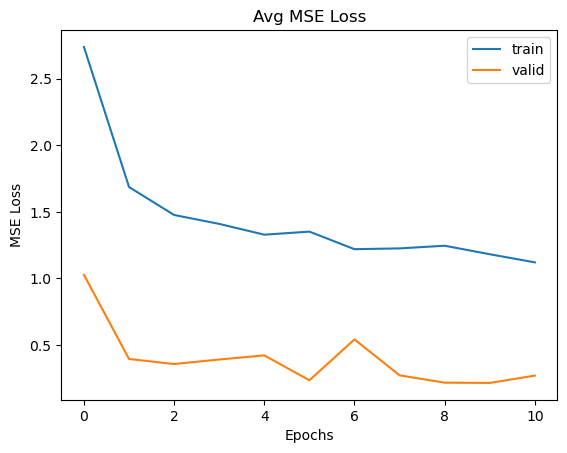

In [20]:
plt.plot(avg_train_metrics['losses'], label='train')
plt.plot(avg_valid_metrics['losses'], label='valid')
plt.title('Avg MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend();

Load best model

In [22]:
# weights_path = r'C:\\Users\\itber\\Documents\\learning\\self_tutorials\\CV_projects\\mars_challenge\\models\\model_9.pth'
model.load_state_dict(torch.load(model_savepath));

## Test Loop

In [23]:
model.eval()

test_metrics = {
        'losses' : AverageMeter()
    }


with torch.no_grad():
    for i, ((image1, image2), speed) in enumerate(test_loader):
        image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

        # pad to ensure that it is divisible by 8
        padder = InputPadder(image1.shape, mode=None)
        image1, image2 = padder.pad(image1, image2)

        # get predictions
        pred_speed = model(image1, image2)

        # compute losses
        loss = criterion(pred_speed, speed)

        # store metrics
        test_metrics['losses'].update(loss.item())

        if i % 50 == 0:
            print(f"test: epoch {e} - MSE loss: {valid_metrics['losses'].avg}")

test: epoch 11 - MSE loss: 0.2689
test: epoch 11 - MSE loss: 0.2689
test: epoch 11 - MSE loss: 0.2689


c:\Users\itber\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
test_metrics['losses'].avg

0.2351

In [30]:
(image1, image2), speed = next(iter(test_loader))

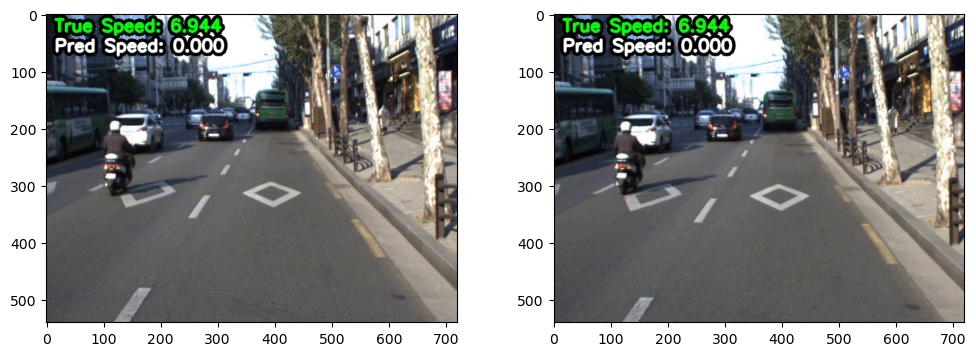

In [31]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(viz(image1[idx, :, :, :].squeeze(), speed[idx], 0))
ax[1].imshow(viz(image2[idx, :, :, :].squeeze(), speed[idx], 0))

In [33]:
_valid_dataset.image_path1, _valid_dataset.image_path2

('C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_882.png',
 'C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_883.png')